In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
#Load dataset
df = pd.read_csv('train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
#Drop irrelevent data
df.drop("Loan_ID", axis=1, inplace=True)

### Here we are filling missing values column-wise instead of dropping rows with missing values.

    When Filling Missing Values is Better
1. Preserves Data
- Dropping rows can reduce your dataset size, especially if many rows have missing values.
- In small or moderate datasets, this loss can be significant and negatively affect model training.
2. Avoids Bias from Missing Not at Random (MNAR)
- Sometimes data is not missing randomly — for example, high-income people not disclosing salary.
- Dropping such rows might bias your model.
3. Improves Generalization
- Many real-world datasets have missing values during prediction time.
- A model trained to handle missing data (via imputation) is often more robust.

    When Dropping Rows is Better
1. Very Few Missing Rows
- If only a tiny percentage (e.g., <5%) of rows have missing values, dropping may be simpler and effective.
2. Missing Values are Random
- If data is missing completely at random (MCAR), dropping may not introduce bias.
3. Irrelevant Rows
- If a row is missing values in critical columns (e.g., target variable), it might be safer to drop it.

In [5]:
#Fill missing values
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].median())

### Encoding categorical variables using Label Encoding
Machine learning models (especially scikit-learn models) cannot handle text or categorical data directly — they expect numerical input. So we convert string categories like "Male", "Female" or "Urban", "Rural" into numbers using LabelEncoder.

LabelEncoder is okay when the categorical variable is ordinal (e.g., Low < Medium < High) or has just 2 categories (binary).

But if the category has no meaningful order, and especially more than 2 classes, you may want to use pd.get_dummies() or OneHotEncoder to avoid introducing false ordinal relationships.

In [6]:
#Encode categorical variables
label_encoders = {} #dictionary to store label encoders of each column
categorical_columns = df.select_dtypes(include='object').columns #list of column names that are of object(string, categorical) type

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col]) #identify unique classes, transform to integers, assign back to same column (replace)
    label_encoders[col] = le #store the encoder in the dictionary using the column name as the key

In [7]:
for col, le in label_encoders.items():
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Married: {'No': np.int64(0), 'Yes': np.int64(1)}
Dependents: {'0': np.int64(0), '1': np.int64(1), '2': np.int64(2), '3+': np.int64(3)}
Education: {'Graduate': np.int64(0), 'Not Graduate': np.int64(1)}
Self_Employed: {'No': np.int64(0), 'Yes': np.int64(1)}
Property_Area: {'Rural': np.int64(0), 'Semiurban': np.int64(1), 'Urban': np.int64(2)}
Loan_Status: {'N': np.int64(0), 'Y': np.int64(1)}


In [8]:
# Split data into features and target
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

    RandomForestClassifier

In [11]:
# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Save model with joblib
joblib.dump(rf_model, "saved_models/random_forest_model.joblib")
# Save encoders
joblib.dump(label_encoders, "saved_models/label_encoders.joblib")

['saved_models/label_encoders.joblib']

In [13]:
y_pred = rf_model.predict(X_test)

print("RandomForest:", accuracy_score(y_test, y_pred))

RandomForest: 0.7479674796747967


In [14]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.42      0.54        43
           1       0.75      0.93      0.83        80

    accuracy                           0.75       123
   macro avg       0.75      0.67      0.68       123
weighted avg       0.75      0.75      0.73       123



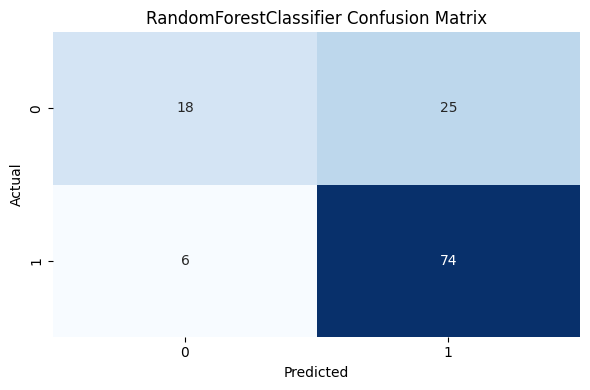

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RandomForestClassifier Confusion Matrix")
plt.tight_layout()
plt.show()

### Now we are going to try a few more models and compare their performance to RandomForrest

In [16]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "model": model,
        "accuracy": acc,
        "confusion_matrix": cm
    }

    print(f"{name} Accuracy: {acc:.2f}")

Logistic Regression Accuracy: 0.79
K-Nearest Neighbors Accuracy: 0.76
Support Vector Machine Accuracy: 0.79
Gradient Boosting Accuracy: 0.75
XGBoost Accuracy: 0.74


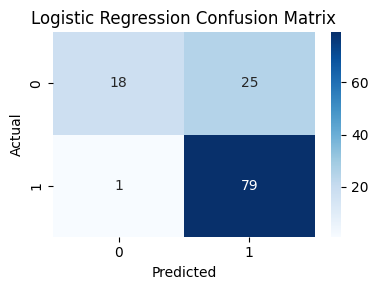

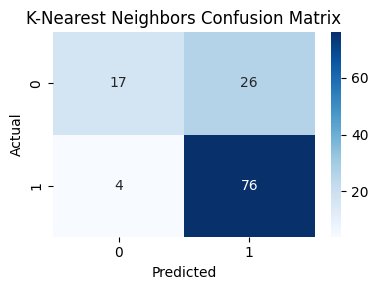

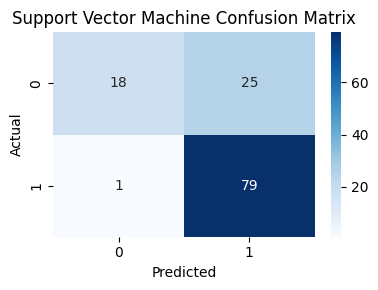

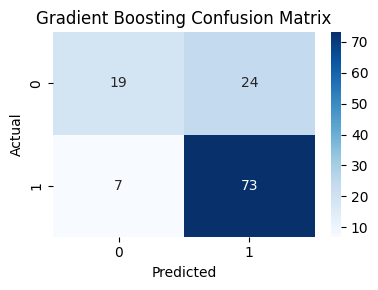

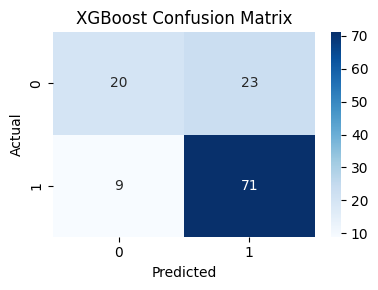

In [17]:
for name, result in results.items():
    plt.figure(figsize=(4, 3))
    sns.heatmap(result["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    Model                   Accuracy	Notes
    Logistic Regression     0.79	    Fast, interpretable, and strong baseline.
    Support Vector Machine	0.79	    Improved significantly after scaling. Performs well on structured data.

In [18]:
# Save all trained models
for name, model in models.items():
    filename = f"saved_models/{name.replace(' ', '_').lower()}_model.joblib"
    joblib.dump(model, filename)